In [1]:
import pickle
import pandas as pd
import numpy as np
import os
import seaborn as sns
import matplotlib.pyplot as plt

from denovo_utils.parsers.constants import AA_MASSES
from psm_utils import PSM



from denovo_utils.analysis.visualization import plot_spectrum
from spectrum_utils.plot import mirror

from denovo_utils.analysis.metrics import (
    aa_match,
    aa_match_metrics,
    aa_precision_recall
)

from peak_pack.feature_generators import PeakFeatureGenerator
from peak_pack.annotation import SpectrumVector, PeptideEvidence
from peak_pack.utils import ion_dict_to_matrix

import logging
logger = logging.getLogger(__name__)

%matplotlib inline

Modification already exists in ModificationsDB. Skipping.


2024-10-18 17:38:08.073405: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-18 17:38:08.082277: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-18 17:38:08.084596: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-18 17:38:08.964620: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: UNKNOWN ERROR (100)


In [2]:
# def plot_mirror(spectrum_id, peptide_1, peptide_2):
#     sage_spec = plot_spectrum(
#         mgf_path=mgf_path,
#         spectrum_id=spectrum_id,
#         peptide=peptide_1,plot=False
#     )
#     denovo_spec = plot_spectrum(
#         mgf_path=mgf_path,
#         spectrum_id=spectrum_id,
#         peptide=peptide_2, plot=False
#     )
#     plt.title(
#         label=f"TOP: {peptide_1}\nBOT: {peptide_2}"
#     )
#     mirror(sage_spec, denovo_spec)

In [2]:
root_path = "/home/samva/Doctorate/data_directory/PXD028735/rescoring_results/LFQ_Orbitrap_DDA_Human_01"
engines = [
    "sage",
    # "casanovo",
    # "instanovo",
    # "pepnet",
    # "novob",
    # "contranovo"
]

rescoring_features = [
    "tic",
    "peak_count",
    "hyperscore",
    "missing_frag_sites",
    "missing_frag_pct",
    "explained_y_pct",
    "explained_b_pct",
    "explained_all_pct",
    "cos",
    "rt_diff",
    "charge_n",
    "ppm_mean"
]

keep_columns = [
    "peptidoform",
    "spectrum_id",
    "is_decoy",
    "score",
    "qvalue",
    "source",
    "provenance_data",
    "metadata"
]
mgf_path = "/home/samva/Doctorate/data_directory/PXD028735/mgf/Orbitrap_QE/reformatted/LFQ_Orbitrap_DDA_Human_01.mgf"

from pyteomics import mgf

mgf_file = mgf.read(mgf_path)

In [3]:
from denovo_utils.parsers import DenovoEngineConverter

parser = DenovoEngineConverter.select("casanovo")
psmlist = parser.parse(
    "/home/samva/Doctorate/data_directory/PXD028735/denovo_results/casanovo/LFQ_Orbitrap_DDA_Human_01.casanovo.mztab",
    mgf_path
)

100%|██████████| 115362/115362 [00:02<00:00, 54827.96it/s]


In [15]:
pd.DataFrame(psmlist['metadata'].tolist())

,aa_scores,calc_mass_to_charge,spectra_ref,scans
0,"0.91022,0.90441,0.52536,0.84621,0.86612,0.91107",392.17240331688004,ms_run[1]:index=0,3675
1,"0.88669,0.70310,0.60171,0.88674,0.88534,0.62881",394.15930031688004,ms_run[1]:index=1,3681
2,"0.91560,0.85586,0.95999,0.96613,0.96421,0.96570",371.68125681688,ms_run[1]:index=2,4361
3,"0.90639,0.93453,0.86701,0.74368,0.93164,0.9267...",527.2427413168799,ms_run[1]:index=3,4369
4,"0.94366,0.92745,0.93501,0.94380,0.94410,0.64032",363.68941631688,ms_run[1]:index=4,4415
...,...,...,...,...
115357,"0.90422,0.90091,0.90196,0.90396,0.90348,0.6837...",1135.93176281688,ms_run[1]:index=118230,139021
115358,"0.85373,0.85222,0.85223,0.85311,0.84915,0.5559...",759.2991197002134,ms_run[1]:index=118231,139024
115359,"0.88428,0.88386,0.79218,0.58313,0.48815,0.8553...",867.4804790335465,ms_run[1]:index=118233,139075
115360,"0.70218,0.43729,0.85510,0.49947,0.58814,0.8486...",872.8059053668799,ms_run[1]:index=118234,139083


In [5]:
pd.concat(
    [
        psmlist.to_dataframe()[["spectrum_id", "run", "source"]],
        pd.DataFrame(psmlist['metadata'].tolist())
    ],
    axis=1
)

,spectrum_id,run,source,aa_scores,calc_mass_to_charge,spectra_ref,scans
0,controllerType=0 controllerNumber=1 scan=3675,LFQ_Orbitrap_DDA_Human_01.casanovo.mztab,Casanovo4.2.0,"0.91022,0.90441,0.52536,0.84621,0.86612,0.91107",392.17240331688004,ms_run[1]:index=0,3675
1,controllerType=0 controllerNumber=1 scan=3681,LFQ_Orbitrap_DDA_Human_01.casanovo.mztab,Casanovo4.2.0,"0.88669,0.70310,0.60171,0.88674,0.88534,0.62881",394.15930031688004,ms_run[1]:index=1,3681
2,controllerType=0 controllerNumber=1 scan=4361,LFQ_Orbitrap_DDA_Human_01.casanovo.mztab,Casanovo4.2.0,"0.91560,0.85586,0.95999,0.96613,0.96421,0.96570",371.68125681688,ms_run[1]:index=2,4361
3,controllerType=0 controllerNumber=1 scan=4369,LFQ_Orbitrap_DDA_Human_01.casanovo.mztab,Casanovo4.2.0,"0.90639,0.93453,0.86701,0.74368,0.93164,0.9267...",527.2427413168799,ms_run[1]:index=3,4369
4,controllerType=0 controllerNumber=1 scan=4415,LFQ_Orbitrap_DDA_Human_01.casanovo.mztab,Casanovo4.2.0,"0.94366,0.92745,0.93501,0.94380,0.94410,0.64032",363.68941631688,ms_run[1]:index=4,4415
...,...,...,...,...,...,...,...
115357,controllerType=0 controllerNumber=1 scan=139021,LFQ_Orbitrap_DDA_Human_01.casanovo.mztab,Casanovo4.2.0,"0.90422,0.90091,0.90196,0.90396,0.90348,0.6837...",1135.93176281688,ms_run[1]:index=118230,139021
115358,controllerType=0 controllerNumber=1 scan=139024,LFQ_Orbitrap_DDA_Human_01.casanovo.mztab,Casanovo4.2.0,"0.85373,0.85222,0.85223,0.85311,0.84915,0.5559...",759.2991197002134,ms_run[1]:index=118231,139024
115359,controllerType=0 controllerNumber=1 scan=139075,LFQ_Orbitrap_DDA_Human_01.casanovo.mztab,Casanovo4.2.0,"0.88428,0.88386,0.79218,0.58313,0.48815,0.8553...",867.4804790335465,ms_run[1]:index=118233,139075
115360,controllerType=0 controllerNumber=1 scan=139083,LFQ_Orbitrap_DDA_Human_01.casanovo.mztab,Casanovo4.2.0,"0.70218,0.43729,0.85510,0.49947,0.58814,0.8486...",872.8059053668799,ms_run[1]:index=118234,139083


In [3]:
from denovo_utils.data import Run, Spectrum, PSM

In [3]:
def convert_peptidoform(peptidoform):
    out = []
    n_mod = peptidoform.properties["n_term"]
    if n_mod is None:
        n_mod = [None]

    # If there is an N-terminal mod, this is seperately tokenized.
    else:
        out.append(("", n_mod))

    for i, aa_mod in enumerate(peptidoform):
        aa, mod = aa_mod
        if mod is None:
            mod = [mod]

        out.append((aa, mod))
    return out

In [4]:
df = []

for engine in engines:
    with open(os.path.join(root_path, engine+".pkl"), "rb") as f:
        print(engine)
        df_engine = pickle.load(f).to_dataframe()
        df_engine = df_engine.loc[:, keep_columns]
        df.append(df_engine)

df = pd.concat(df, ignore_index=True)

sage


In [5]:
df.peptidoform.apply(lambda x: x.proforma)

0                                EYIPTVFDNYSAQSAVDGR/2
1                      LATGSDDNC[UNIMOD:4]AAFFEGPPFK/2
2                     EM[UNIMOD:35]EENFAVEAANYQDTIGR/2
3        TTTFFQFC[UNIMOD:4]NADSGTLLC[UNIMOD:4]TDVAAR/2
4                                   GYSYDLEVEQAYDLAR/2
                             ...                      
90812                               EVTRSMEQEHQKILNK/3
90813                  [UNIMOD:5]-MRNHTIHPQGRDSYNLNK/3
90814            QAAPKGGAPHHYC[UNIMOD:4]GAAKLWSDPHHR/3
90815                                  LNMGRNSFHADKR/3
90816                           AVFDIHLLKPKYPHRQVDQR/4
Name: peptidoform, Length: 90817, dtype: object

In [6]:
from psm_utils import Peptidoform

pep1=convert_peptidoform(
    peptidoform=Peptidoform('[UNIMOD:1]-TDDLSEPMQNFEEFPM[UNIMOD:35]QC[UNIMOD:4]/3')
)
pep2=convert_peptidoform(
    peptidoform=Peptidoform('[UNIMOD:1]-DTLDEPMSFEQNEFPM[UNIMOD:35]QC[UNIMOD:4]/3')
)

In [7]:
m, p, l, ierr = aa_match(
    peptide1=pep1,
    peptide2=pep2,
    aa_dict={}
)

In [8]:
ierr

[('Q/E', True), ('M/F', True), ('F/M', True), ('E/Q', True)]

In [14]:
def get_evidence(peptidoform, mgf_file, spectrum_id, ion_types=['b1', 'b2', 'y1', 'y2'], neutral_losses=['', '-H2O1']):

    spectrum = mgf_file.get_by_id(spectrum_id)

    if isinstance(peptidoform, str):
        peptidoform = Peptidoform(peptidoform)
    psm = PSM(
        peptidoform=peptidoform,
        spectrum_id=spectrum_id,
        precursor_mz=peptidoform.theoretical_mz
    )

    sv = SpectrumVector(ion_types=ion_types, neutral_losses=neutral_losses)
    sv.parse(psm, spectrum)

    matrix = np.concatenate(
        [
            ion_dict_to_matrix(
                ion_dict=m,
                ion_types=ion_types,
                n=sv.n
            )
            for m in sv.experimental_intensity.values()
        ],
        axis=0
    )

    pe = PeptideEvidence(
        peptidoform=sv.peptidoform,
        ion_matrix=matrix,
        evidence_labels=[
            ion_type + nl 
            for ion_type in ion_types 
            for nl in neutral_losses 
        ]
    )
    return sv, pe

issue is the following:

The ambiguous tag indices don't count the n-terminal modification as a seperate index

The match boolean, coutns n term as index

In [93]:
p1 = Peptidoform('[UNIMOD:1]-TDDLSEPMQNFEEFPM[UNIMOD:35]QC[UNIMOD:4]/3')
p2 = Peptidoform('[UNIMOD:1]-DTDLSEPMQEFNEFPM[UNIMOD:35]QC[UNIMOD:4]/3')
p3 = Peptidoform('DDTSLEPMQNFEEFPM[UNIMOD:35]QC[UNIMOD:4]/3')
spectrum_id='controllerType=0 controllerNumber=1 scan=139024'

sv, pe_1 = get_evidence(
    peptidoform=p1,
    mgf_file=mgf_file,
    spectrum_id=spectrum_id,
)
sv, pe_2 = get_evidence(
    peptidoform=p2,
    mgf_file=mgf_file,
    spectrum_id=spectrum_id,
)
sv, pe_3 = get_evidence(
    peptidoform=p3,
    mgf_file=mgf_file,
    spectrum_id=spectrum_id,
)


pep1=convert_peptidoform(
    peptidoform=p1
)
pep2=convert_peptidoform(
    peptidoform=p2
)
pep3=convert_peptidoform(
    peptidoform=p3
)

_, pep_match, (match_1, match_2), iso_errs = aa_match(
    peptide1=pep1,
    peptide2=pep3,
    aa_dict={}
)


In [88]:
def filter_out_indices(sequence, index_pairs):    
    filtered_sequence = []
    current_position = 0
    
    for start, end in index_pairs:
        # Append the sequence from the current position to the start of the range to be removed
        filtered_sequence.extend(sequence[current_position:start])
        # Move the current position to the end of the range to be removed
        current_position = end + 1  # Assuming end is inclusive
    
    # Append any remaining elements after the last index pair
    filtered_sequence.extend(sequence[current_position:])
    
    return np.array(filtered_sequence)

def evaluate_isobaricity(pe, aa_match_array):

    # Last element in match array is precursor mass matching
    if pe.peptidoform.properties['n_term'] is not None:
        # N-term mods are seperate match index.
        aa_match_array = aa_match_array[1:-1] 
    else:
        aa_match_array = aa_match_array[:-1] 
    
    return aa_match_array[pe.evidence].all()

In [96]:
_, pep_match, (match_1, match_2), iso_errs = aa_match(
    peptide1=pep1,
    peptide2=pep2,
    aa_dict={}
)


evaluate_isobaricity(
    pe_1, aa_match_array=match_2
)

True

In [91]:
pe_1

<TDDL><SEPM><QNFEE>FPM[UNIMOD:35]QC[UNIMOD:4]/3

In [94]:
pe_2

<DTDL><SEPM><QEFNE>FPM[UNIMOD:35]QC[UNIMOD:4]/3

In [83]:
pe_1.evidence.shape

(17,)

In [82]:
match_1[1:].shape

(18,)

In [76]:
for a, b, c in zip(pe_1.evidence, p1.parsed_sequence, match_1[1:]):
    print(a, c, b)

False False ('T', None)
False False ('D', None)
False False ('D', None)
True False ('L', None)
False False ('S', None)
False True ('E', None)
False True ('P', None)
True True ('M', None)
False True ('Q', None)
False True ('N', None)
False True ('F', None)
False True ('E', None)
True True ('E', None)
True True ('F', None)
True True ('P', None)
True True ('M', [UnimodModification('35', None, None)])
True True ('Q', None)


In [81]:
for a, b, c in zip(pe_3.evidence, p3.parsed_sequence, match_2):
    print(a, c, b)

False False ('D', None)
True False ('D', None)
False False ('T', None)
False False ('S', None)
False False ('L', None)
False True ('E', None)
False True ('P', None)
False True ('M', None)
False True ('Q', None)
False True ('N', None)
False True ('F', None)
False True ('E', None)
True True ('E', None)
True True ('F', None)
True True ('P', None)
True True ('M', [UnimodModification('35', None, None)])
True True ('Q', None)


In [63]:
# USE IT LIKE THIS !!! 

for a, b, c in zip(pe_3.evidence, p1.parsed_sequence, match_2):
    print(a, c, b)

False False ('T', None)
True False ('D', None)
False False ('D', None)
False False ('L', None)
False False ('S', None)
False True ('E', None)
False True ('P', None)
False True ('M', None)
False True ('Q', None)
False True ('N', None)
False True ('F', None)
False True ('E', None)
True True ('E', None)
True True ('F', None)
True True ('P', None)
True True ('M', [UnimodModification('35', None, None)])
True True ('Q', None)


In [53]:
pe_1.evidence

array([False, False, False,  True, False, False, False,  True, False,
       False, False, False,  True,  True,  True,  True,  True])

In [44]:
pe_2.evidence

array([False, False, False, False, False, False, False,  True, False,
       False, False, False,  True,  True,  True,  True,  True])

In [42]:
match_2

array([ True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [22]:
match_1

array([ True,  True,  True,  True, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [36]:
len(p1.parsed_sequence)

18

In [41]:
pe_1.ambiguous_tag_indices+1

array([[ 1,  5],
       [ 5,  9],
       [ 9, 14]])

In [38]:
for x, y in zip([p1.properties['n_term']] + p1.parsed_sequence, match_1):
    print(x,y)

[UnimodModification('1', None, None)] True
('T', None) True
('D', None) True
('D', None) True
('L', None) False
('S', None) False
('E', None) True
('P', None) True
('M', None) True
('Q', None) True
('N', None) True
('F', None) True
('E', None) True
('E', None) True
('F', None) True
('P', None) True
('M', [UnimodModification('35', None, None)]) True
('Q', None) True
('C', [UnimodModification('4', None, None)]) True


In [18]:
iso_errs

[('Q/E', True),
 ('M/F', True),
 ('F/M', True),
 ('E/Q', True),
 ('E/Q', True),
 ('F/M', True),
 ('N/D', True),
 ('Q/E', True),
 ('M/F', True),
 ('E/Q', True)]

In [238]:
pe_1.peptidoform.parsed_sequence

[('T', None),
 ('D', None),
 ('D', None),
 ('L', [MassModification(25.55, None, None)]),
 ('S', None),
 ('E', None),
 ('P', None),
 ('M', None),
 ('Q', None),
 ('N', None),
 ('F', None),
 ('E', None),
 ('E', None),
 ('F', None),
 ('P', None),
 ('M', [UnimodModification('35', None, None)]),
 ('Q', None),
 ('C', [UnimodModification('4', None, None)])]

In [239]:
pe_1.peptidoform.properties['n_term'][]

[UnimodModification('1', None, None)]

In [226]:
[1,2,3,4][1:4]

[2, 3, 4]

In [225]:
np.array([1,2,3,4])[1:4]

array([2, 3, 4])

In [224]:
len(pe_1.peptidoform.parsed_sequence)

18

In [228]:
len(pe_1.peptidoform.parsed_sequence)

18

In [230]:
pe_1.peptidoform.parsed_sequence

[('T', None),
 ('D', None),
 ('D', None),
 ('L', [MassModification(25.55, None, None)]),
 ('S', None),
 ('E', None),
 ('P', None),
 ('M', None),
 ('Q', None),
 ('N', None),
 ('F', None),
 ('E', None),
 ('E', None),
 ('F', None),
 ('P', None),
 ('M', [UnimodModification('35', None, None)]),
 ('Q', None),
 ('C', [UnimodModification('4', None, None)])]

In [232]:
pe_1.peptidoform.parsed_sequence[17:18][0][1][0].prefix_name

'UNIMOD'

In [233]:
pe_1.peptidoform.parsed_sequence[2:5][1][1][0].prefix_name

'Obs'

In [235]:
Peptidoform('KDR[Obs:+25.44]RP').parsed_sequence

[('K', None),
 ('D', None),
 ('R', [MassModification(25.44, None, None)]),
 ('R', None),
 ('P', None)]

In [182]:
pe.get_ambiguous_tags()

[[0, 4], [4, 8], [8, 13]]

In [151]:
df.source.value_counts()

PepNet           118245
Casanovo4.2.0    115362
InstaNovo        114725
NovoB            114064
sage              90817
ContraNovo        57640
Name: source, dtype: int64

In [8]:
%matplotlib inline

In [38]:
df["is_decoy"] = df.is_decoy.fillna(True)
gt_spectra = {
    k: convert_peptidoform(v["peptidoform"]) for k, v in
        df.loc[
        (df.source == "sage") &
        (df.qvalue < .01) &
        (~df.is_decoy),
        ["spectrum_id", "peptidoform"]
    ].set_index("spectrum_id").to_dict("index").items()
}

In [65]:
df.loc[1, 'peptidoform'].sequence

'LATGSDDNCAAFFEGPPFK'

In [69]:
gt_spectra

{'controllerType=0 controllerNumber=1 scan=106107': [('E', [None]),
  ('Y', [None]),
  ('I', [None]),
  ('P', [None]),
  ('T', [None]),
  ('V', [None]),
  ('F', [None]),
  ('D', [None]),
  ('N', [None]),
  ('Y', [None]),
  ('S', [None]),
  ('A', [None]),
  ('Q', [None]),
  ('S', [None]),
  ('A', [None]),
  ('V', [None]),
  ('D', [None]),
  ('G', [None]),
  ('R', [None])],
 'controllerType=0 controllerNumber=1 scan=108067': [('L', [None]),
  ('A', [None]),
  ('T', [None]),
  ('G', [None]),
  ('S', [None]),
  ('D', [None]),
  ('D', [None]),
  ('N', [None]),
  ('C', [UnimodModification('4', None, None)]),
  ('A', [None]),
  ('A', [None]),
  ('F', [None]),
  ('F', [None]),
  ('E', [None]),
  ('G', [None]),
  ('P', [None]),
  ('P', [None]),
  ('F', [None]),
  ('K', [None])],
 'controllerType=0 controllerNumber=1 scan=94752': [('E', [None]),
  ('M', [UnimodModification('35', None, None)]),
  ('E', [None]),
  ('E', [None]),
  ('N', [None]),
  ('F', [None]),
  ('A', [None]),
  ('V', [None]),
 

In [68]:
amb_aa = ['L', 'I',  'D', 'E', 'F']
modifications = ['N[UNIMOD:7]', 'Q[UNIMOD:7]', 'M[UNIMOD:35]']

df[df.source=='sage'].peptidoform.apply(
    lambda x: True in [i in x.sequence for i in amb_aa] or 
              True in [i in x.proforma for i in modifications]
).value_counts()

True     74510
False    16307
Name: peptidoform, dtype: int64

In [67]:
df[df.source=='sage'].peptidoform.apply(
    lambda x: 'I' in x.sequence or "L" in x.sequence
).value_counts()

True     81392
False     9425
Name: peptidoform, dtype: int64

In [39]:
def get_scores(row, spec_dict):
    if row["spectrum_id"] not in spec_dict.keys():
        return None
    else:
        peptide_gt = spec_dict[row["spectrum_id"]]
        peptide_denovo = convert_peptidoform(row["peptidoform"])

        result = aa_match(peptide_gt, peptide_denovo, {})
        return result

In [40]:
from tqdm import tqdm
tqdm.pandas()

df["result"] = df.progress_apply(lambda x: get_scores(x, gt_spectra), axis=1)

100%|██████████| 206179/206179 [00:03<00:00, 57643.23it/s] 


In [42]:
df.loc[0, 'result']

(array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,
         True]),
 True,
 (array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True]),
  array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
          True,  True,  True,  True,  True,  True,  True,  True,  True,
          True])))

In [12]:
df_td = df[
    (df.spectrum_id.isin(df[df.source=='sage'].spectrum_id.tolist())) &
    (df.source.isin(["sage", 'Casanovo4.2.0']))]

In [ ]:
casanovo = df_td[
    (df_td.source=="Casanovo4.2.0") &
    (df_td['result'].apply(lambda x: ~x[1]))
]

In [42]:
df_td = pd.concat(
    [df_td[df_td.source=='sage'], casanovo]
)

In [43]:
df_td['is_decoy'] = df_td.apply(lambda x: 'denovo' if x['source']=='Casanovo4.2.0' else x['is_decoy'], axis=1)

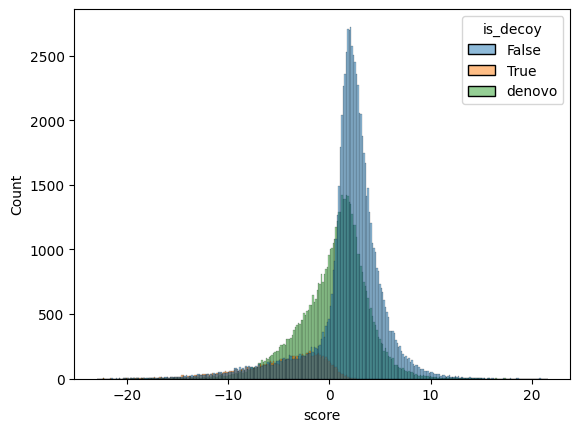

In [45]:
sns.histplot(
    df_td,
    x='score',
    hue='is_decoy'
)
plt.show()

In [12]:
metrics = {}
for engine in df.source.unique():

    df_subset_results = df.loc[
        (df.source==engine) &
        (df["result"].notna()),
        "result"
    ]
    aa_matches_batch = [
        (x[0], x[1]) for x in df_subset_results
    ]

    # First sequence provided was ground truth
    n_aa_true = np.sum(
        [x[2][0].shape[0] for x in df_subset_results]
    )
    n_aa_pred = np.sum(
        [x[2][1].shape[0] for x in df_subset_results]
    )
    aa_metrics = aa_match_metrics(
        aa_matches_batch=aa_matches_batch,
        n_aa_true=n_aa_true,
        n_aa_pred=n_aa_pred
    )
    metrics[engine] = {
        "aa_precision": aa_metrics[0],
        "aa_recall": aa_metrics[1],
        "pep_precision": aa_metrics[2]
    }

In [13]:
metrics_df = pd.DataFrame(metrics).T.reset_index()
spectra_counts = df[["source", "result"]].dropna().source.value_counts().reset_index().rename(columns={"source": "spectra_predicted"})
spectra_counts["spectra_predicted"] = spectra_counts["spectra_predicted"] / spectra_counts.loc[spectra_counts["index"]=="sage", "spectra_predicted"].values[0]
metrics_df = pd.merge(metrics_df, spectra_counts, on="index")

metrics_df

,index,aa_precision,aa_recall,pep_precision,spectra_predicted
0,sage,1.000000,1.000000,1.000000,1.000000
1,Casanovo4.2.0,0.628311,0.628744,0.460562,0.998200
2,InstaNovo,0.589484,0.589883,0.422607,0.998140
3,PepNet,0.485899,0.482888,0.272286,1.000000
4,NovoB,0.639764,0.641555,0.464095,0.992831
5,ContraNovo,0.702020,0.706330,0.546593,0.500675


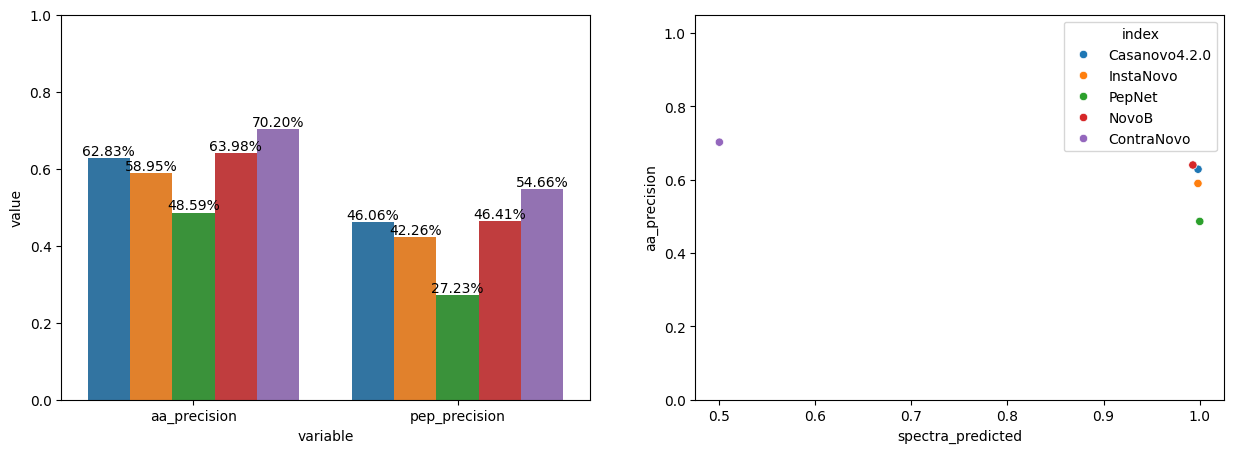

In [16]:
# Static plots to show global performance considering everything which is predicted
fig, ax = plt.subplots(1, 2, figsize=(15,5))
barplot = sns.barplot(
    metrics_df.loc[metrics_df['index']!='sage',
        ["index", "aa_precision", "pep_precision"]].melt(id_vars="index"),
    x="variable",
    hue="index",
    y="value",
    ax=ax[0],
    legend=False
)
ax[0].set_ylim((0,1))

sns.scatterplot(
    metrics_df.loc[metrics_df['index']!='sage'],
    x="spectra_predicted",
    y="aa_precision",
    hue="index",
    ax=ax[1]
)
ax[1].set_ylim((0,1.05))

for p in barplot.patches:
    height = p.get_height()
    barplot.text(
        p.get_x() + p.get_width() / 2.0,  # X-coordinate: center of the bar
        height,  # Y-coordinate: height of the bar
        f'{height*100:.2f}%',  # Text to be displayed
        ha='center',  # Horizontal alignment
        va='bottom'   # Vertical alignment
    )
plt.show()

## Precision recall plots

### 1. Amino acid level

The only ones with positional scores are Casanovo, PepNet and ContraNovo. For the other, I will need to change source code to extract those aswell

In [159]:
positional_score_name = {
    'Casanovo4.2.0': "aa_scores",
    "PepNet": "positional_scores",
    "ContraNovo": "aa_scores"
}

In [160]:
def extract_positional_scores(row):
    if row["source"] not in positional_score_name.keys():
        return None
    else:
        arr = np.array(eval(row["metadata"][positional_score_name[row["source"]]]))
        return np.array([np.round(x, 5) for x in arr])
    
def extract_score_arrays_row(row):
    scores = row["aa_scores"]
    correctness = row["result"][2][1]

    if scores.shape != correctness.shape:
        # Especially for Contranovo, where multiple nterm tokens are allowed
        logging.warning("Unequal score shapes")
        while scores.shape != correctness.shape:
            n_term_score = np.mean(scores[:2])
            scores = scores[1::]
            scores[0] = n_term_score

    assert scores.shape == correctness.shape

    scores_all = scores
    scores_correct = scores[correctness]
    n = len(scores)
    return (scores_correct, scores_all, n)

def extract_score_arrays(df, engine):

    df_subset = df.loc[
        (df.source==engine) &
        (df["result"].notna()),
        ["result", "aa_scores"]]
    score_arrays = df_subset.apply(
        extract_score_arrays_row, axis=1
    )
    return score_arrays

def calculate_pr_df(score_arrays, n_aa_total=None):
    precisions = []
    recalls = []
    aa_scores_correct=np.concatenate(score_arrays.apply(lambda x: x[0]).to_list())
    aa_scores_all=np.concatenate(score_arrays.apply(lambda x: x[1]).to_list())
    if n_aa_total is None:
        n_aa_total=np.sum(score_arrays.apply(lambda x: x[2]))

    sorted_array = np.sort(aa_scores_all)
    max_scores = sorted_array[-50::]

    assert np.min(aa_scores_all)<.5
    thresholds = np.concatenate([
        np.linspace(np.min(aa_scores_all),.5,50),
        np.linspace(.5,.9, 100),
        np.linspace(.90, .99, 50),
        np.linspace(.99, 1, 50),
        max_scores
    ])

    for threshold in tqdm(thresholds):
        aa_precision, aa_recall = aa_precision_recall(
            aa_scores_correct=aa_scores_correct,
            aa_scores_all=aa_scores_all,
            n_aa_total=n_aa_total,
            threshold=threshold
        )
        precisions.append(aa_precision)
        recalls.append(aa_recall)
    
    return pd.DataFrame(
        {
            "aa_precision": precisions,
            "aa_recall": recalls,
            "threshold": thresholds
        }
    )


In [161]:
n_aa_all = np.sum(df[(df.source=='sage') & (df.result.notna())]["result"].apply(lambda x: len(x[0])))

In [162]:
df["aa_scores"] = df.apply(
    extract_positional_scores, axis=1
)

In [19]:
pr_dfs = []
pr_dfs_all = []

for engine in positional_score_name.keys():
    pr_df = calculate_pr_df(extract_score_arrays(df, engine))
    pr_df["engine"]  = engine
    pr_dfs.append(pr_df)

    pr_df = calculate_pr_df(extract_score_arrays(df, engine), n_aa_all)
    pr_df["engine"]  = engine
    pr_dfs_all.append(pr_df)

 75%|███████▍  | 224/300 [00:20<00:06, 11.15it/s]/home/samva/Doctorate/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:381: RuntimeWarning: invalid value encountered in scalar divide
  return n_aa_correct / n_aa_predicted, n_aa_correct / n_aa_total
 75%|███████▍  | 224/300 [00:20<00:06, 10.95it/s]/home/samva/Doctorate/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:381: RuntimeWarning: invalid value encountered in scalar divide
  return n_aa_correct / n_aa_predicted, n_aa_correct / n_aa_total
 83%|████████▎ | 248/300 [00:20<00:04, 12.07it/s]/home/samva/Doctorate/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:381: RuntimeWarning: invalid value encountered in scalar divide
  return n_aa_correct / n_aa_predicted, n_aa_correct / n_aa_total
 83%|████████▎ | 248/300 [00:20<00:04, 12.08it/s]/home/samva/Doctorate/DeNovo_Benchmark/package_du/denovo_utils/analysis/metrics.py:381: RuntimeWarning: invalid value encountered in scalar divide
  return n_aa_corr

In [20]:
pr = pd.concat(pr_dfs, ignore_index=True)
pr_all = pd.concat(pr_dfs_all, ignore_index=True)

In [193]:
pr = pd.concat([
    pr,
    pd.DataFrame({
        "engine": ["ContraNovo", "PepNet"],
        "aa_recall": [0,0],
        "aa_precision": [pr.loc[pr.engine=="ContraNovo", "aa_precision"].max(),
                         pr.loc[pr.engine=="PepNet", "aa_precision"].max()]
    })
], axis=0, ignore_index=True)

# pr_all = pd.concat([
#     pr_all,
#     pd.DataFrame({
#         "engine": ["ContraNovo", "PepNet"],
#         "aa_recall": [0,0],
#         "aa_precision": [pr_all.loc[pr_all.engine=="ContraNovo", "aa_precision"].max(),
#                          pr_all.loc[pr_all.engine=="PepNet", "aa_precision"].max()]
#     })
# ], axis=0, ignore_index=True)

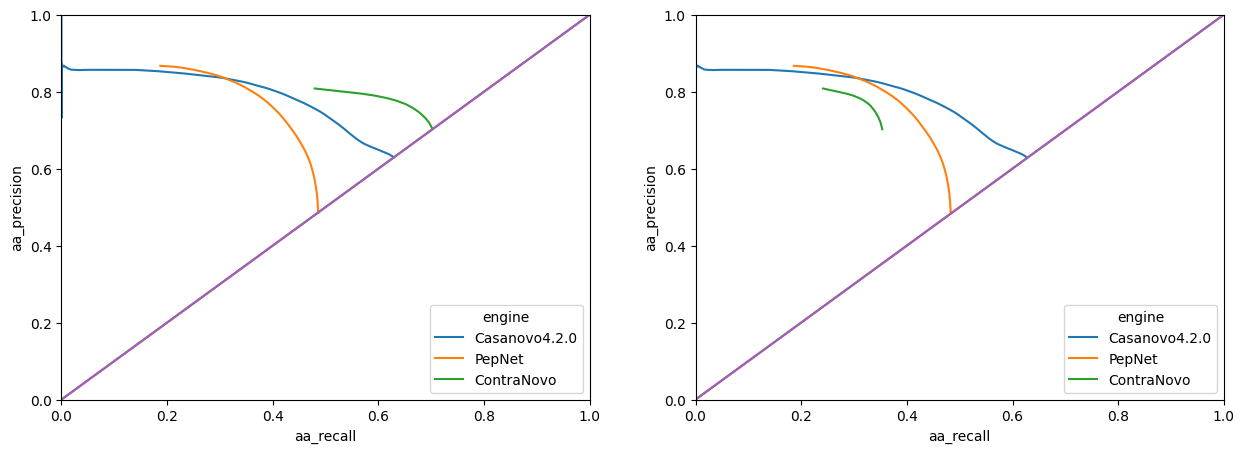

In [209]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

sns.lineplot(
    pr,
    x="aa_recall",
    y="aa_precision",
    hue="engine",
    ax=ax[0]
)
ax[0].set_xlim((0,1))
ax[0].set_ylim((0,1))
ax[0].plot([(0,0),(1,1)])

sns.lineplot(
    pr_all,
    x="aa_recall",
    y="aa_precision",
    hue="engine",
    ax=ax[1]
)
ax[1].set_xlim((0,1))
ax[1].set_ylim((0,1))
ax[1].plot([(0,0),(1,1)])

(0.0, 1.0)

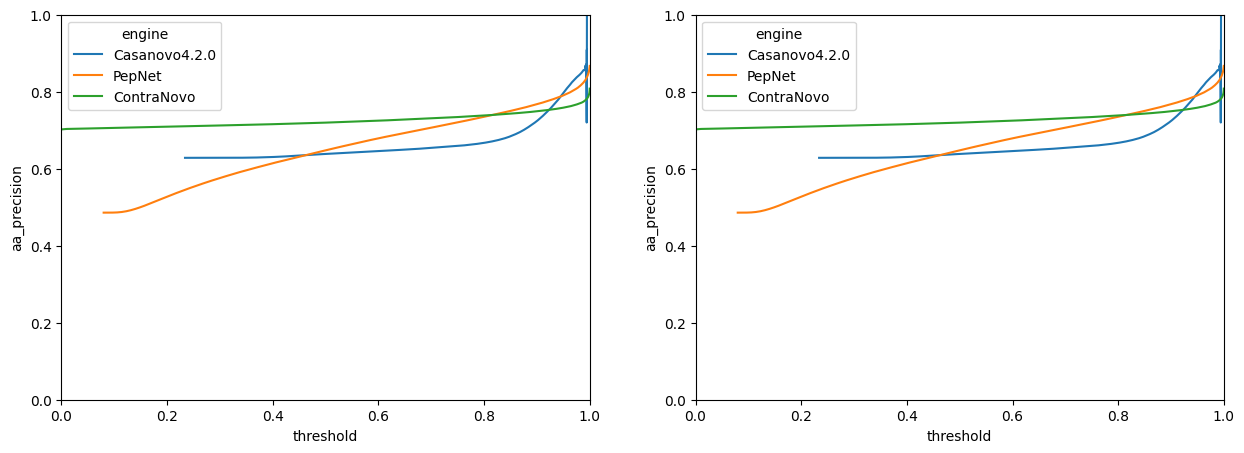

In [212]:
fig, ax = plt.subplots(1,2,figsize=(15,5))

sns.lineplot(
    pr,
    x="threshold",
    y="aa_precision",
    hue="engine",
    ax=ax[0]
)
ax[0].set_xlim((0,1))
ax[0].set_ylim((0,1))

sns.lineplot(
    pr_all,
    x="threshold",
    y="aa_precision",
    hue="engine",
    ax=ax[1]
)
ax[1].set_xlim((0,1))
ax[1].set_ylim((0,1))

### 2. Peptide level

In [21]:
df["correct_peptide"] = df["result"].apply(lambda x: x[1] if x is not None else False)

In [22]:
df_filtered = df[df.spectrum_id.isin(gt_spectra)]

In [30]:
df_filtered.loc[
    (df_filtered.source=='Casanovo4.2.0'),
    ['peptidoform', 'spectrum_id', 'correct_peptide']
].reset_index(drop=True).to_pickle('casanovo_identifications.pkl')

In [165]:
accuracy = df_filtered.groupby("source").correct_peptide.value_counts()
accuracy.name = "value"

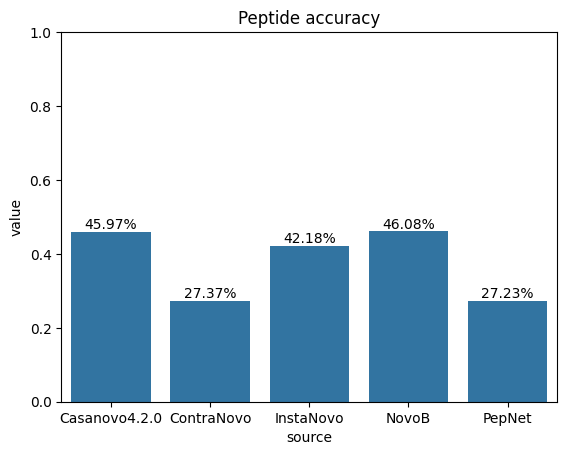

In [166]:
accuracy = df_filtered.groupby("source").correct_peptide.value_counts()
accuracy.name = "value"
accuracy = accuracy.reset_index()
accuracy["value"] = accuracy["value"] / accuracy.loc[accuracy.source=="sage", "value"].values[0]

plt.ylim((0,1))
barplot = sns.barplot(
    accuracy[
        (accuracy.correct_peptide) &
        (accuracy.source != "sage")
    ],
    x="source",
    y="value"
)

plt.title("Peptide accuracy")
for p in barplot.patches:
    height = p.get_height()
    barplot.text(
        p.get_x() + p.get_width() / 2.0,  # X-coordinate: center of the bar
        height,  # Y-coordinate: height of the bar
        f'{height*100:.2f}%',  # Text to be displayed
        ha='center',  # Horizontal alignment
        va='bottom'   # Vertical alignment
    )
plt.show()

In [167]:
from denovo_utils.analysis.evaluation import get_precision_coverage_df

In [23]:
df.source.unique()

array(['sage', 'Casanovo4.2.0', 'InstaNovo', 'PepNet', 'NovoB',
       'ContraNovo'], dtype=object)

In [237]:
def process_score(row):
    if (row["source"] in ["Casanovo4.2.0", "ContraNovo"]) & (row["before_rescoring_score"] < 0):
        return 1 + row["before_rescoring_score"]
    return row["before_rescoring_score"]

df["before_rescoring_score"] = df["provenance_data"].apply(lambda x: x["before_rescoring_score"])
df["before_rescoring_score"] = df.apply(
    process_score, axis=1
)

In [238]:
peptide_pcs = []
for engine in ['Casanovo4.2.0', 'InstaNovo', 'PepNet', 'NovoB', 'ContraNovo']:
    print(engine)
    peptide_pc = get_precision_coverage_df(
        df=df, 
        source=engine, 
        score_col="score", 
        correctness_col="correct_peptide",
        ground_truth_source = "sage"
    )
    peptide_pcs.append(peptide_pc)

Casanovo4.2.0


/home/samva/Doctorate/DeNovo_Benchmark/package_du/denovo_utils/analysis/evaluation.py:94: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: x["TP"] / (x["TP"] + x["FP"]), axis=1


InstaNovo


/home/samva/Doctorate/DeNovo_Benchmark/package_du/denovo_utils/analysis/evaluation.py:94: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: x["TP"] / (x["TP"] + x["FP"]), axis=1


PepNet


/home/samva/Doctorate/DeNovo_Benchmark/package_du/denovo_utils/analysis/evaluation.py:94: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: x["TP"] / (x["TP"] + x["FP"]), axis=1


NovoB


/home/samva/Doctorate/DeNovo_Benchmark/package_du/denovo_utils/analysis/evaluation.py:94: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: x["TP"] / (x["TP"] + x["FP"]), axis=1


ContraNovo


/home/samva/Doctorate/DeNovo_Benchmark/package_du/denovo_utils/analysis/evaluation.py:94: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: x["TP"] / (x["TP"] + x["FP"]), axis=1


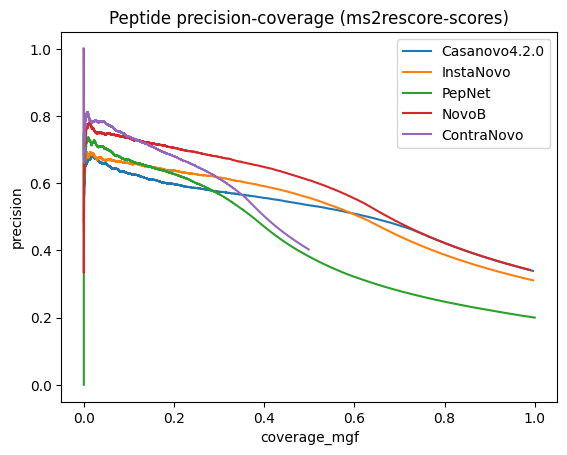

In [239]:
plt.title("Peptide precision-coverage (ms2rescore-scores)")
for engine, pc in zip(
    ['Casanovo4.2.0', 'InstaNovo', 'PepNet', 'NovoB', 'ContraNovo'],
    peptide_pcs
):
    sns.lineplot(
        pc,
        x="coverage_mgf",
        y="precision",
        label=engine
    )

Casanovo4.2.0


/home/samva/Doctorate/DeNovo_Benchmark/package_du/denovo_utils/analysis/evaluation.py:94: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: x["TP"] / (x["TP"] + x["FP"]), axis=1


InstaNovo


/home/samva/Doctorate/DeNovo_Benchmark/package_du/denovo_utils/analysis/evaluation.py:94: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: x["TP"] / (x["TP"] + x["FP"]), axis=1


PepNet


/home/samva/Doctorate/DeNovo_Benchmark/package_du/denovo_utils/analysis/evaluation.py:94: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: x["TP"] / (x["TP"] + x["FP"]), axis=1


NovoB


/home/samva/Doctorate/DeNovo_Benchmark/package_du/denovo_utils/analysis/evaluation.py:94: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: x["TP"] / (x["TP"] + x["FP"]), axis=1


ContraNovo


/home/samva/Doctorate/DeNovo_Benchmark/package_du/denovo_utils/analysis/evaluation.py:94: RuntimeWarning: invalid value encountered in scalar divide
  lambda x: x["TP"] / (x["TP"] + x["FP"]), axis=1


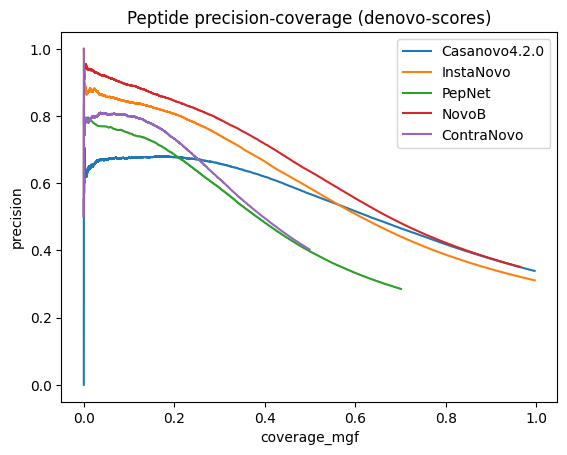

In [240]:
peptide_pcs_denovo = []
for engine in ['Casanovo4.2.0', 'InstaNovo', 'PepNet', 'NovoB', 'ContraNovo']:
    print(engine)
    peptide_pc = get_precision_coverage_df(
        df=df, 
        source=engine, 
        score_col="before_rescoring_score", 
        correctness_col="correct_peptide",
        ground_truth_source = "sage"
    )
    peptide_pcs_denovo.append(peptide_pc)


plt.title("Peptide precision-coverage (denovo-scores)")
for engine, pc in zip(
    ['Casanovo4.2.0', 'InstaNovo', 'PepNet', 'NovoB', 'ContraNovo'],
    peptide_pcs_denovo
):
    sns.lineplot(
        pc,
        x="coverage_mgf",
        y="precision",
        label=engine
    )

In [246]:
df.columns

Index(['peptidoform', 'spectrum_id', 'is_decoy', 'score', 'qvalue', 'source',
       'provenance_data', 'metadata', 'result', 'aa_scores', 'correct_peptide',
       'before_rescoring_score'],
      dtype='object')

In [254]:
df["proforma"] = df["peptidoform"].apply(lambda x: x.proforma)

In [250]:
df[
    (df.source=="Casanovo4.2.0") &
    (~df.correct_peptide) &
    (df.before_rescoring_score > .95) &
    (df.spectrum_id.isin(gt_spectra.keys()))
].sort_values("before_rescoring_score", ascending=False)[["peptidoform", "spectrum_id", "score", "before_rescoring_score"]]

,peptidoform,spectrum_id,score,before_rescoring_score
143598,"((F, None), (P, None), (P, None), (Y, None), (...",controllerType=0 controllerNumber=1 scan=66061,2.042514,0.992115
150880,"((S, None), (G, None), (G, None), (L, None), (...",controllerType=0 controllerNumber=1 scan=74095,7.992475,0.991883
95631,"((L, None), (K, None), (P, None), (G, None), (...",controllerType=0 controllerNumber=1 scan=11948,2.152308,0.991769
91243,"((Y, None), (F, None), (A, None), (P, None), (...",controllerType=0 controllerNumber=1 scan=6207,2.519289,0.991607
181552,"((T, None), (T, None), (G, None), (L, None), (...",controllerType=0 controllerNumber=1 scan=108570,12.172519,0.991564
...,...,...,...,...
197647,"((M, [UNIMOD:35]), (L, None), (P, None), (T, N...",controllerType=0 controllerNumber=1 scan=127575,3.794394,0.950046
184880,"((F, None), (V, None), (F, None), (D, None), (...",controllerType=0 controllerNumber=1 scan=112435,0.830427,0.950028
191789,"((L, None), (D, None), (F, None), (E, None), (...",controllerType=0 controllerNumber=1 scan=120547,-3.496603,0.950016
153325,"((D, None), (A, None), (L, None), (V, None), (...",controllerType=0 controllerNumber=1 scan=76796,0.027334,0.950010


In [268]:
spectrum_id = "controllerType=0 controllerNumber=1 scan=108570"
selection = df[
    (df.source.isin(["sage", "Casanovo4.2.0"])) &
    (df.spectrum_id==spectrum_id)
][["proforma", "source", "score", "before_rescoring_score", "provenance_data"]].reset_index(drop=True)
selection = pd.concat([selection[["proforma", "source", "score", "before_rescoring_score"]],
                       pd.DataFrame(selection["provenance_data"].tolist())[["rt_diff", "cos", "hyperscore", "missing_frag_sites"]]],
                       axis=1)
selection

,proforma,source,score,before_rescoring_score,rt_diff,cos,hyperscore,missing_frag_sites
0,AILGSYDSELTPAEYSPQLTR/2,sage,2.366958,0.794085,0.599997,0.902572,25.792885,5
1,TTGLVMDSGDGVTHTVPLYEGY/2,Casanovo4.2.0,12.172519,0.991564,0.270905,0.905358,91.629889,0


In [17]:
df[
    (df.source=='sage') &
    (df.spectrum_id=="controllerType=0 controllerNumber=1 scan=108570")
]

,peptidoform,spectrum_id,is_decoy,score,qvalue,source,provenance_data,metadata,result
65283,"((A, None), (I, None), (L, None), (G, None), (...",controllerType=0 controllerNumber=1 scan=108570,False,2.366958,0.000203,sage,{'sage_filename': '/home/samva/Doctorate/data_...,{'peptide_evidence': AI<LG><SY>D<SE>LTPAEYS<PQ...,"([True, True, True, True, True, True, True, Tr..."


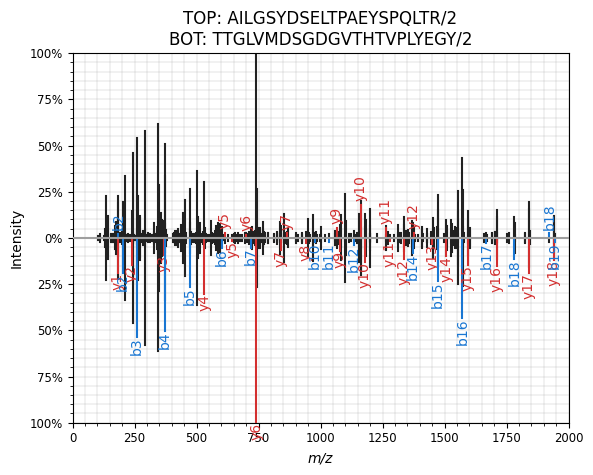

In [269]:
plot_mirror(
    spectrum_id=spectrum_id,
    peptide_1="AILGSYDSELTPAEYSPQLTR/2",
    peptide_2="TTGLVMDSGDGVTHTVPLYEGY/2"
)

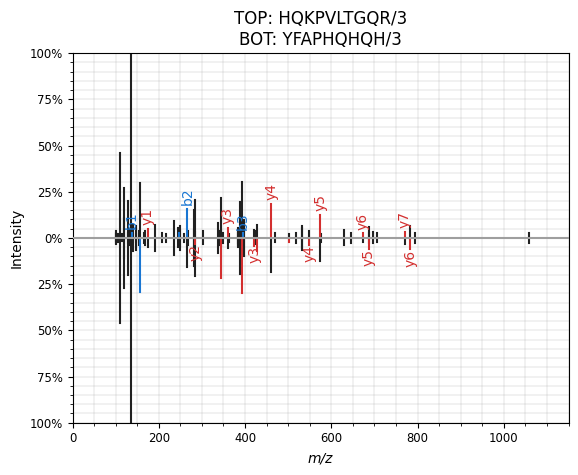

In [263]:
plot_mirror(
    spectrum_id=spectrum_id,
    peptide_1="HQKPVLTGQR/3",
    peptide_2="YFAPHQHQH/3"
)

### 3. PSM-by-PSM level (MS2Rescore-based)

In [19]:
gt_scores = {k: v["score"] for k,v in df.loc[
            (df.source=="sage") &
            (df.spectrum_id.isin(gt_spectra.keys())),
            ["spectrum_id", "score"]
        ].set_index("spectrum_id").to_dict("index").items()}

In [ ]:
df_gt_spectra = df[
    (df.spectrum_id.isin(gt_spectra.keys()))
]
df_gt_spectra["score_diff"] = df_gt_spectra.apply(lambda x: x["score"]-gt_scores[x["spectrum_id"]], axis=1)
df_gt_spectra["higher_ms2rescore_score"] = df_gt_spectra.score_diff > 0
df_filtered = df_gt_spectra[~df_gt_spectra.correct_peptide]

In [170]:
df_filtered.groupby("spectrum_id").source.nunique().value_counts()

4    17709
5    10861
1     8702
3     8370
2     7260
Name: source, dtype: int64

In [171]:
common_wrong_spectra = df_filtered.groupby("spectrum_id").source.nunique()
common_wrong_spectra_ids = common_wrong_spectra[common_wrong_spectra==5].index

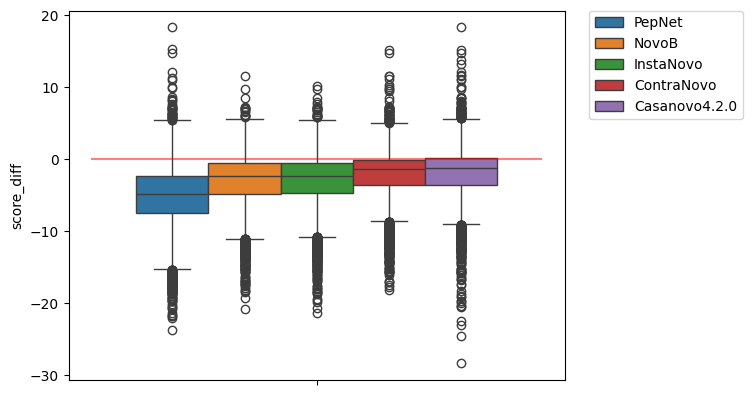

In [172]:
hue_order = df_filtered[
    df_filtered.spectrum_id.isin(common_wrong_spectra_ids)
].groupby("source").score_diff.mean().sort_values().index
sns.boxplot(
    df_filtered[
        df_filtered.spectrum_id.isin(common_wrong_spectra_ids)
    ],
    hue="source",
    y="score_diff",
    hue_order=hue_order
)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.hlines(0, xmin=-.5, xmax=.5, color="r", alpha=.5)

In [173]:
common_df = df_filtered[
        df_filtered.spectrum_id.isin(common_wrong_spectra_ids)
    ]
higher_scores = common_df.groupby("source").higher_ms2rescore_score.value_counts(normalize=True)

In [174]:
def set_pred_type(row):
    if row["correct_peptide"]:
        return "match"
    if row["higher_ms2rescore_score"]:
        return "higher_score"
    return "lower_score"
df_gt_spectra["prediction_type"] = df_gt_spectra.apply(set_pred_type, axis=1)

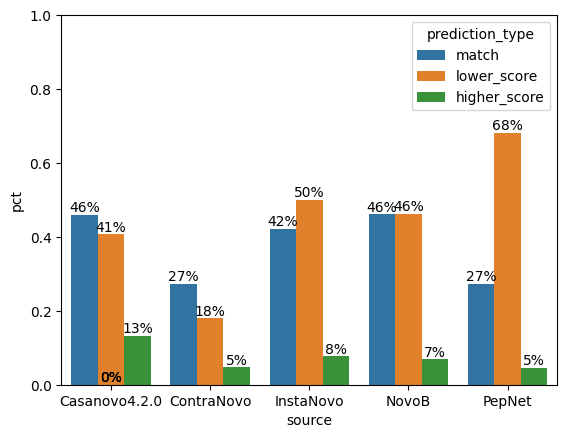

In [176]:
prediction_type_pct = df_gt_spectra.groupby("source").prediction_type.value_counts() / len(gt_spectra)
prediction_type_pct.name = "pct"
prediction_type_pct = prediction_type_pct.reset_index()

barplot = sns.barplot(
    prediction_type_pct[prediction_type_pct["source"]!="sage"],
    y="pct",
    x="source",
    hue="prediction_type"
)
plt.ylim((0,1))

for p in barplot.patches:
    height = p.get_height()
    barplot.text(
        p.get_x() + p.get_width() / 2.0,  # X-coordinate: center of the bar
        height,  # Y-coordinate: height of the bar
        f'{height*100:.0f}%',  # Text to be displayed
        ha='center',  # Horizontal alignment
        va='bottom'   # Vertical alignment
    )
plt.show()

In [182]:
df_gt_spectra["hyperscore"] = df_gt_spectra["provenance_data"].apply(lambda x: x["hyperscore"])

In [197]:
df[df.spectrum_id=="controllerType=0 controllerNumber=1 scan=4932"].apply(
    lambda x: (x["source"], x["metadata"]["peptide_evidence"], x["provenance_data"]["hyperscore"]), axis=1
).tolist()

[('sage', HGS<NI>EAM[UNIMOD:35]SK/2, 25.93065104895682),
 ('Casanovo4.2.0', HG<TAAA>EAM[UNIMOD:35]SK/2, 23.954127666554243),
 ('InstaNovo', HGS<AGV>EAM[UNIMOD:35]SK/2, 25.93065104895682),
 ('PepNet', HG<SV>AGEAFSK/2, 21.584302517295804),
 ('NovoB', HGS<NL>EAM[UNIMOD:35]SK/2, 25.93065104895682)]

In [198]:
df_gt_spectra.loc[df_gt_spectra.spectrum_id=="controllerType=0 controllerNumber=1 scan=4932", [
    "score_diff",
    "source"
]]

,score_diff,source
38655,0.000000,sage
90836,-0.144253,Casanovo4.2.0
206198,0.145604,InstaNovo
320923,-3.512249,PepNet
439168,-0.024844,NovoB


In [226]:
case_example = df.loc[
    (df.spectrum_id=="controllerType=0 controllerNumber=1 scan=4932") &
    (df.source.isin(["sage", "Casanovo4.2.0","InstaNovo"])),
    ["source", "metadata", "provenance_data"]
].reset_index(drop=True)
case_example["peptide_evidence"] = case_example.apply(lambda x: x["metadata"]["peptide_evidence"], axis=1)
case_example = pd.concat([case_example[["source", "peptide_evidence"]], pd.DataFrame(case_example.provenance_data.tolist())], axis=1)

case_example[["source", "peptide_evidence", "hyperscore", "rt_diff", "cos", "missing_frag_sites", "explained_all_pct", "tic", "peak_count"]]

,source,peptide_evidence,hyperscore,rt_diff,cos,missing_frag_sites,explained_all_pct,tic,peak_count
0,sage,HGS<NI>EAM[UNIMOD:35]SK/2,25.930651,4.559491,0.906079,1,0.626255,1.087492e+06,35
1,Casanovo4.2.0,HG<TAAA>EAM[UNIMOD:35]SK/2,23.954128,4.817605,0.907412,3,0.617884,1.087492e+06,35
2,InstaNovo,HGS<AGV>EAM[UNIMOD:35]SK/2,25.930651,4.579794,0.928118,2,0.626255,1.087492e+06,35


<Axes: title={'center': 'TOP: HGS<NI>EAM[UNIMOD:35]SK/2\nBOT: HGS<AGV>EAM[UNIMOD:35]SK/2'}, xlabel='m/z', ylabel='Intensity'>

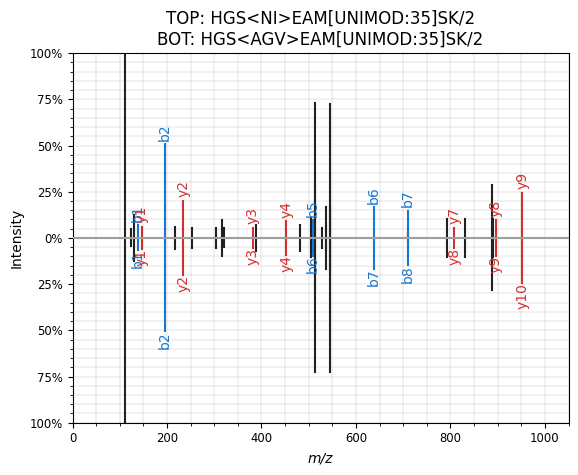

In [227]:
sage_spec = plot_spectrum(
    mgf_path=mgf_path,
    spectrum_id="controllerType=0 controllerNumber=1 scan=4932",
    peptide="HGSNIEAM[UNIMOD:35]SK/2",plot=False
)
denovo_spec = plot_spectrum(
    mgf_path=mgf_path,
    spectrum_id="controllerType=0 controllerNumber=1 scan=4932",
    peptide="HGSAGVEAM[UNIMOD:35]SK/2", plot=False
)
plt.title(
    label=f"TOP: HGS<NI>EAM[UNIMOD:35]SK/2\nBOT: HGS<AGV>EAM[UNIMOD:35]SK/2"
)
mirror(sage_spec, denovo_spec)

<Axes: title={'center': 'TOP: LIEDKPR/2\nBOT: HSASLTVR/2'}, xlabel='m/z', ylabel='Intensity'>

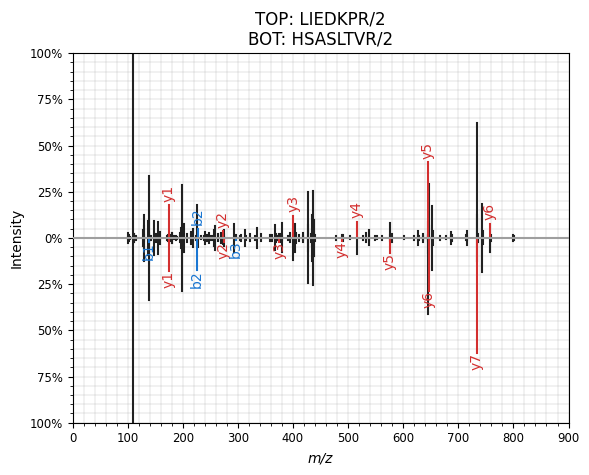

In [223]:
sage_spec = plot_spectrum(
    mgf_path=mgf_path,
    spectrum_id="controllerType=0 controllerNumber=1 scan=9028",
    peptide="LIEDKPR/2",plot=False
)
denovo_spec = plot_spectrum(
    mgf_path=mgf_path,
    spectrum_id="controllerType=0 controllerNumber=1 scan=9028",
    peptide="HSASLTVR/2", plot=False
)
plt.title(
    label=f"TOP: LIEDKPR/2\nBOT: HSASLTVR/2"
)
mirror(sage_spec, denovo_spec)

Which engine consistently gets sequences with highest ms2rescore score

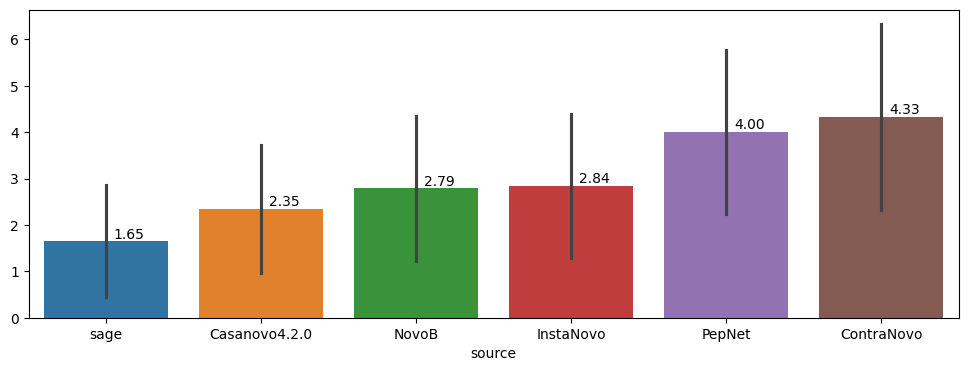

In [303]:
score_matrix = df_gt_spectra[["spectrum_id", "score", "source"]].pivot_table(
    index="spectrum_id", columns="source", values="score"
).fillna(-100)
score_matrix = round(score_matrix, 2)
score_matrix_rank = score_matrix.rank(axis=1, ascending=False, method="min")

plt.figure(figsize=(12,4))
barplot = sns.barplot(
    score_matrix.rank(axis=1, ascending=False, method="min")[[
        "sage", "Casanovo4.2.0", "NovoB", "InstaNovo", "PepNet", "ContraNovo"
    ]], errorbar="sd")

# Annotate the bars
for p in barplot.patches:
    height = p.get_height()
    barplot.text(
        p.get_x() +.15 + p.get_width() / 2.0,  # X-coordinate: center of the bar
        height,  # Y-coordinate: height of the bar
        f'{height:.2f}',  # Text to be displayed
        ha='center',  # Horizontal alignment
        va='bottom'   # Vertical alignment
    )

plt.show()

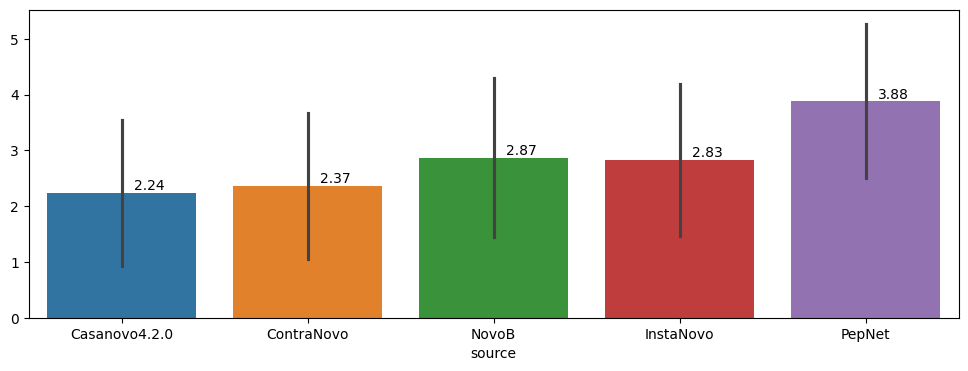

In [307]:
score_matrix = common_df[["spectrum_id", "score", "source"]].pivot_table(
    index="spectrum_id", columns="source", values="score"
).fillna(-100)
score_matrix = round(score_matrix, 2)
score_matrix_rank = score_matrix.rank(axis=1, ascending=False, method="min")

plt.figure(figsize=(12,4))
barplot = sns.barplot(
    score_matrix.rank(axis=1, ascending=False, method="min")[[
        "Casanovo4.2.0", "ContraNovo", "NovoB", "InstaNovo", "PepNet"
    ]], errorbar="sd")

# Annotate the bars
for p in barplot.patches:
    height = p.get_height()
    barplot.text(
        p.get_x() +.15 + p.get_width() / 2.0,  # X-coordinate: center of the bar
        height,  # Y-coordinate: height of the bar
        f'{height:.2f}',  # Text to be displayed
        ha='center',  # Horizontal alignment
        va='bottom'   # Vertical alignment
    )

plt.show()

## TODO analysis:

- <s> Which features for mokapot are dominant for rescored bad and rescored good denovo psms </s>
- Spectralis/instanovo+ comparison and plotting
- Per engine: Using different scores for PR-plot of peptides
- Overlap plots
- Distinction of which spectra are well predicted by certain engines and not by others
- Exploration of isobaric space: For x missing fragmentation sites, what is the number of possible alternative sequences while matching the same peaks?

# Which features are dominant
## 1. For good predictions

In [323]:
common_df.groupby("source").higher_ms2rescore_score.value_counts()

source         higher_ms2rescore_score
Casanovo4.2.0  False                      7826
               True                       3035
ContraNovo     False                      8317
               True                       2544
InstaNovo      False                      9117
               True                       1744
NovoB          False                      9204
               True                       1657
PepNet         False                      9846
               True                       1015
Name: higher_ms2rescore_score, dtype: int64

In [373]:
higher_scores = common_df[common_df.higher_ms2rescore_score].reset_index(drop=True)
higher_scores = pd.concat([
    higher_scores.loc[:,higher_scores.columns!="provenance_data"],
    pd.DataFrame(higher_scores.provenance_data.tolist())
], axis=1)
lower_scores = common_df[~common_df.higher_ms2rescore_score].reset_index(drop=True)
lower_scores = pd.concat([
    lower_scores.loc[:,lower_scores.columns!="provenance_data"],
    pd.DataFrame(lower_scores.provenance_data.tolist())
], axis=1)

In [374]:
higher_scores_sage = df[
    (df.source=="sage") &
    (df.spectrum_id.isin(higher_scores.spectrum_id))
].reset_index(drop=True)
higher_scores_sage = pd.concat([
    higher_scores_sage.loc[:,higher_scores_sage.columns!="provenance_data"],
    pd.DataFrame(higher_scores_sage.provenance_data.tolist())
], axis=1)

lower_scores_sage = df[
    (df.source=="sage") &
    (df.spectrum_id.isin(lower_scores.spectrum_id))
].reset_index(drop=True)
lower_scores_sage = pd.concat([
    lower_scores_sage.loc[:,lower_scores_sage.columns!="provenance_data"],
    pd.DataFrame(lower_scores_sage.provenance_data.tolist())
], axis=1)

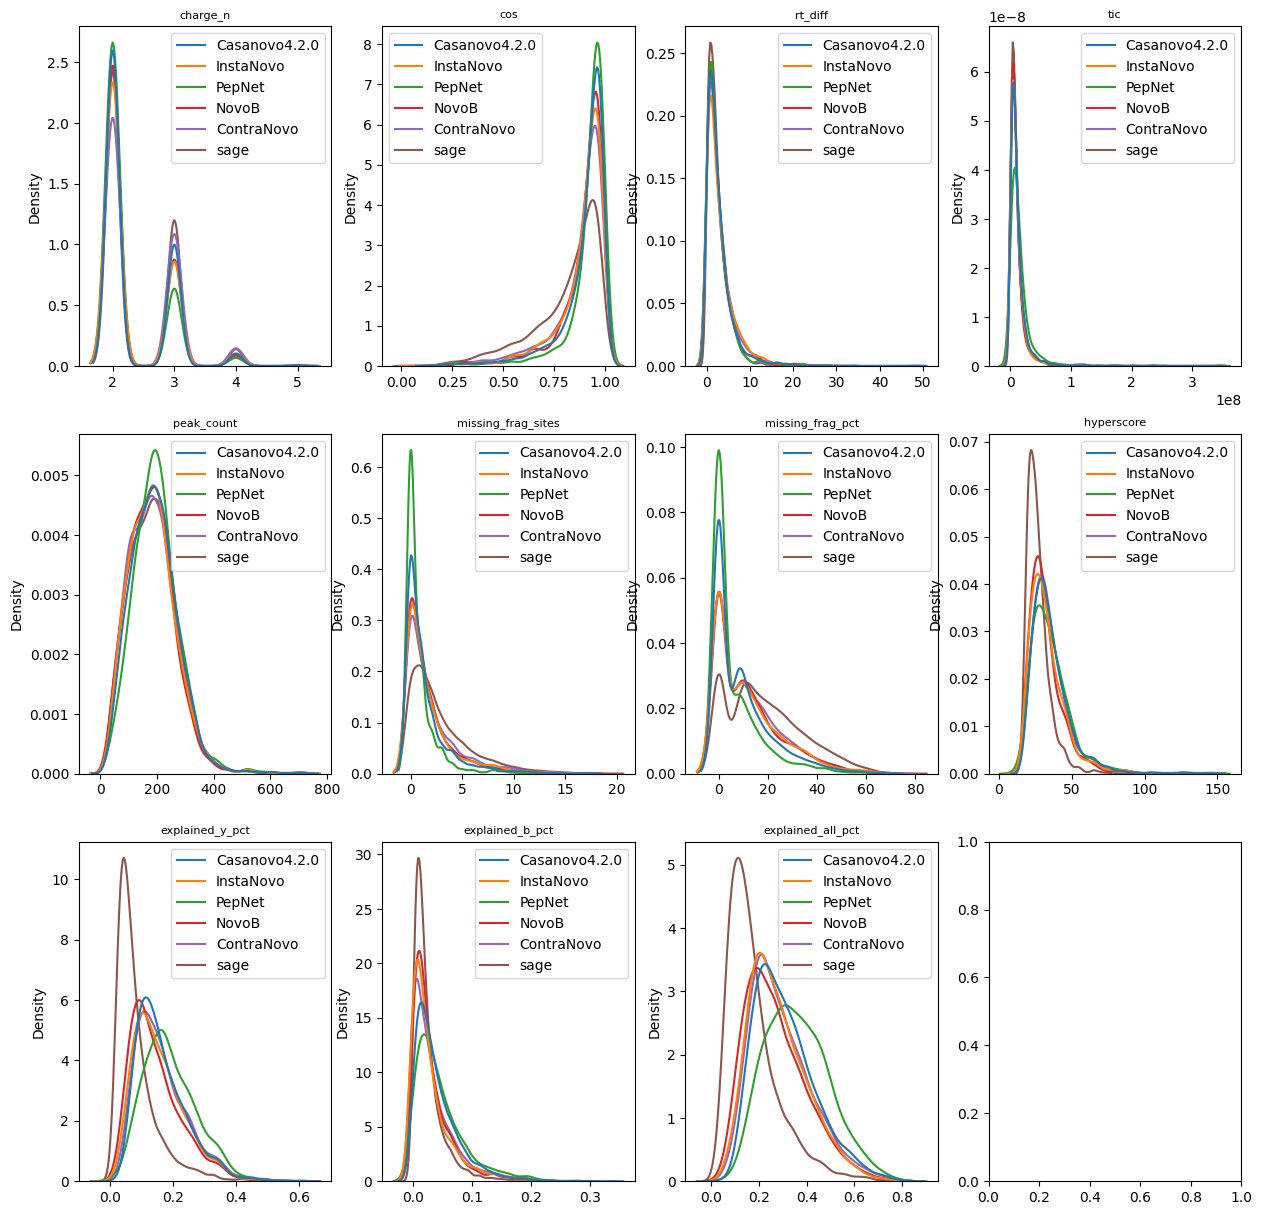

In [362]:
features=[
    'charge_n', 'cos', 'rt_diff', 'tic', 'peak_count', 'missing_frag_sites',
    'missing_frag_pct', 'hyperscore', 'explained_y_pct', 'explained_b_pct',
    'explained_all_pct'
]
n=0
labels = higher_scores["source"].tolist()+higher_scores_sage["source"].tolist()
fig, ax = plt.subplots(3,4, figsize=(15,15))
for x in range(3):
    for y in range(4):
        if n==len(features):
            break
        sns.kdeplot(
            x=higher_scores.loc[:, features[n]].tolist() + \
                higher_scores_sage.loc[:, features[n]].tolist(),
            hue=labels,
            ax=ax[x,y],
            common_norm=False
        )
        ax[x,y].set_title(features[n], fontsize=8)
        n+=1

## 2. For bad predictions

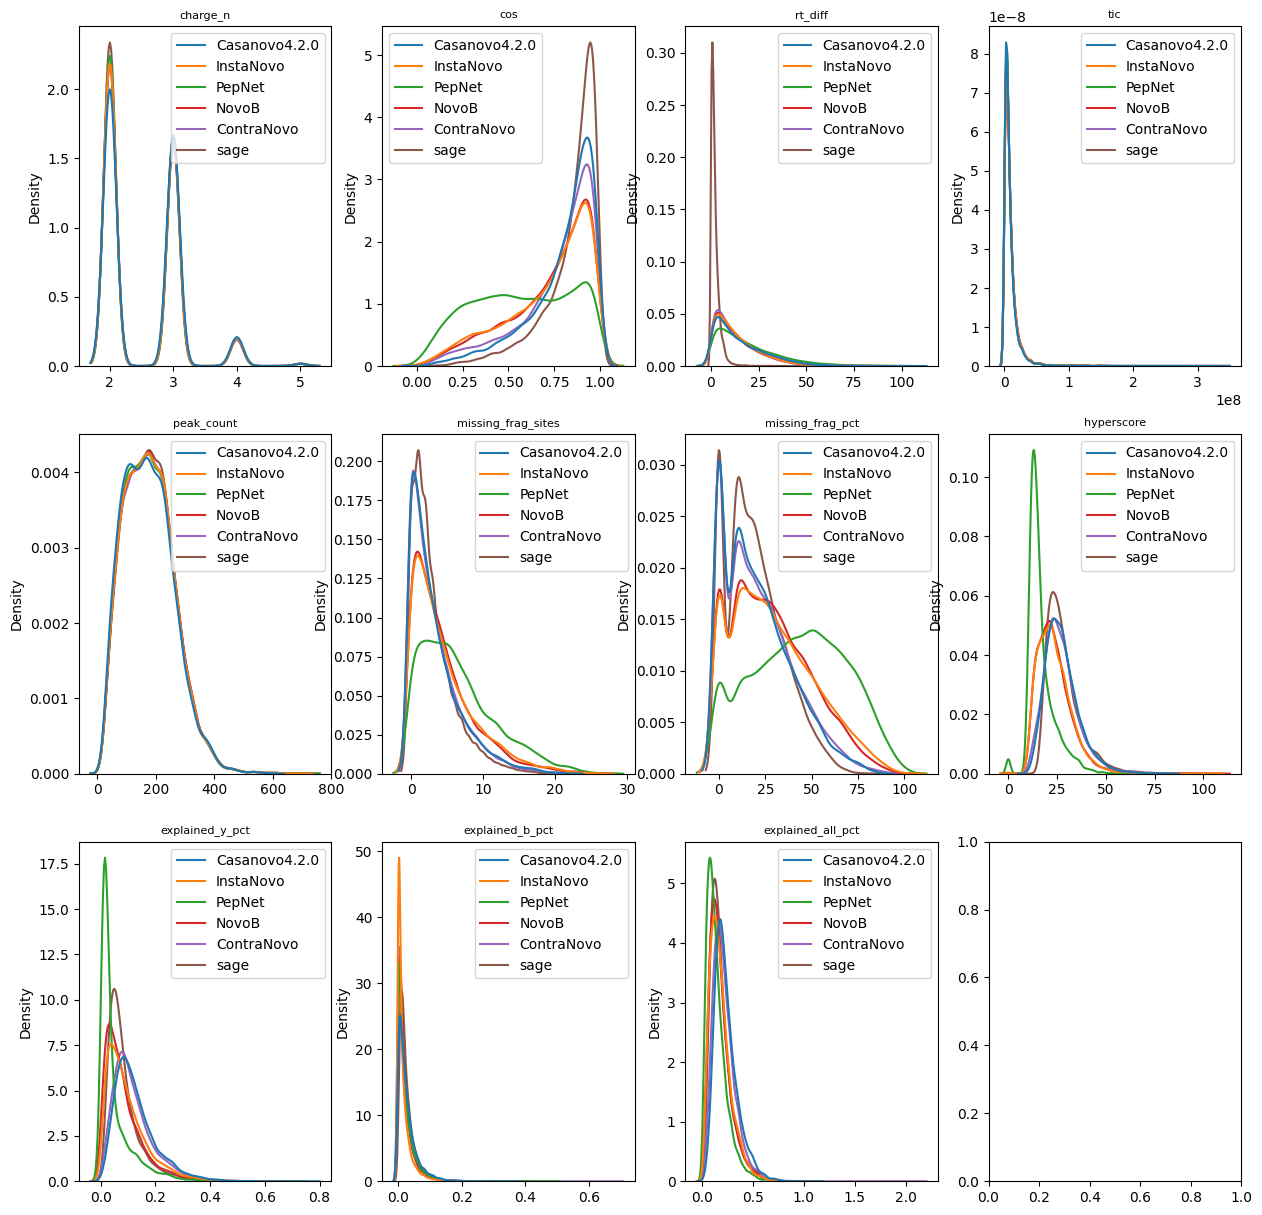

In [376]:
features=[
    'charge_n', 'cos', 'rt_diff', 'tic', 'peak_count', 'missing_frag_sites',
    'missing_frag_pct', 'hyperscore', 'explained_y_pct', 'explained_b_pct',
    'explained_all_pct'
]
n=0
labels = lower_scores["source"].tolist()+lower_scores_sage["source"].tolist()
fig, ax = plt.subplots(3,4, figsize=(15,15))
for x in range(3):
    for y in range(4):
        if n==len(features):
            break
        sns.kdeplot(
            x=lower_scores.loc[:, features[n]].tolist() + \
                lower_scores_sage.loc[:, features[n]].tolist(),
            hue=labels,
            ax=ax[x,y],
            common_norm=False
        )
        ax[x,y].set_title(features[n], fontsize=8)
        n+=1

Apply SHAP here!

## Spectralis and instanovo+

In [377]:
root_spectralis = "/home/samva/Doctorate/data_directory/PXD028735/postprocessing"
spectralis_ea_casanovo = os.path.join(root_spectralis, "casanovo/LFQ_Orbitrap_DDA_Ecoli_01_annotated_ea.csv")
spectralis_ea_contranovo = os.path.join(root_spectralis, "contranovo/LFQ_Orbitrap_DDA_Condition_B_Sample_Alpha_02_annotated_ea.csv")